# Shakespeare Character Genders

Replicating [Determining the Gender of Shakespeare’s Characters by Matt Olson](http://cs229.stanford.edu/proj2013/Olson-DeterminingTheGenderOfShakespearesCharacters.pdf).

## Imports

In [1]:
from os import listdir
from bs4 import BeautifulSoup
import pandas as pd
from nltk.tokenize import word_tokenize
import numpy as np
from nltk.corpus import stopwords
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut

## Data Loading

### Load Gender Labels

In [2]:
df = pd.read_csv('all_globe_name_id.csv', 
            header=None, 
            names=['role_id', 'role', 'file_name', 'blank', 'gender', 'initials'])
df = df.drop(labels=['blank', 'initials'], axis=1)

In [3]:
df['gender'] = df['gender'].str.upper()

In [4]:
df['speech_count'] = 0
df['line_count'] = 0
df['total_words'] = 0
df

,role_id,role,file_name,gender,speech_count,line_count,total_words
0,tim.,TIMON of Athens,Globe_Shakespeare/tim.xml,MALE,0,0,0
1,lucul.,LUCULLUS,Globe_Shakespeare/tim.xml,MALE,0,0,0
2,sem.,SEMPRONIUS,Globe_Shakespeare/tim.xml,MALE,0,0,0
3,ven.,VENTIDIUS,Globe_Shakespeare/tim.xml,MALE,0,0,0
4,alcib.,ALCIBIADES,Globe_Shakespeare/tim.xml,MALE,0,0,0
...,...,...,...,...,...,...,...
1116,serv.,Servant,Globe_Shakespeare/ham.xml,MALE,0,0,0
1117,sail.,Sailor,Globe_Shakespeare/ham.xml,MALE,0,0,0
1118,mess.,Mess.,Globe_Shakespeare/ham.xml,MALE,0,0,0
1119,lord.,Lord.,Globe_Shakespeare/ham.xml,MALE,0,0,0


## Files

In [5]:
files = [f for f in listdir('Globe_Shakespeare')]

In [6]:
base = 'Globe_Shakespeare/'

for file in files:
    file_name = base + file

    with open(file_name, 'r') as tei:
        soup = BeautifulSoup(tei, 'lxml')

        for speech in soup.find_all('sp'):
            for tag in speech.find_all(['stage', 'speaker']):
                tag.decompose()

            # Count 'l' and 'lb' because files are not consistent
            lines = speech.find_all(['l', 'lb'])
            
            text = speech.get_text()
            words = [word for word in word_tokenize(text) if word.isalpha()]
            
            df.loc[(df['file_name'] == file_name) & (df['role_id'] == speech.get('who')), 'speech_count'] += 1
            df.loc[(df['file_name'] == file_name) & (df['role_id'] == speech.get('who')), 'line_count'] += len(lines)
            df.loc[(df['file_name'] == file_name) & (df['role_id'] == speech.get('who')), 'total_words'] += len(words)

In [7]:
df['avg_words_per_speech'] = df['total_words'] / df['speech_count']
df

,role_id,role,file_name,gender,speech_count,line_count,total_words,avg_words_per_speech
0,tim.,TIMON of Athens,Globe_Shakespeare/tim.xml,MALE,210,2481,6225,29.642857
1,lucul.,LUCULLUS,Globe_Shakespeare/tim.xml,MALE,5,54,191,38.200000
2,sem.,SEMPRONIUS,Globe_Shakespeare/tim.xml,MALE,2,78,204,102.000000
3,ven.,VENTIDIUS,Globe_Shakespeare/tim.xml,MALE,2,27,59,29.500000
4,alcib.,ALCIBIADES,Globe_Shakespeare/tim.xml,MALE,39,474,1167,29.923077
...,...,...,...,...,...,...,...,...
1116,serv.,Servant,Globe_Shakespeare/ham.xml,MALE,1,3,9,9.000000
1117,sail.,Sailor,Globe_Shakespeare/ham.xml,MALE,2,10,39,19.500000
1118,mess.,Mess.,Globe_Shakespeare/ham.xml,MALE,2,15,36,18.000000
1119,lord.,Lord.,Globe_Shakespeare/ham.xml,MALE,3,9,67,22.333333


## Balance data

### Get female speakers with more than 30 lines

In [8]:
female_speakers = df.loc[(df['gender'] == 'FEMALE') & (df['line_count'] > 30)]
female_speakers = female_speakers.sort_values('speech_count', ascending=False)
female_speakers

,role_id,role,file_name,gender,speech_count,line_count,total_words,avg_words_per_speech
369,ant-9,Cleopatra,Globe_Shakespeare/ant.xml,FEMALE,204,1369,4627,22.681373
156,ros.,ROSALIND,Globe_Shakespeare/ayl.xml,FEMALE,201,1693,5648,28.099502
775,des.,DESDEMONA,Globe_Shakespeare/oth.xml,FEMALE,165,1122,2729,16.539394
900,isab.,ISABELLA,Globe_Shakespeare/mm.xml,FEMALE,129,1252,2972,23.038760
450,jul.,JULIET,Globe_Shakespeare/rom.xml,FEMALE,118,1641,4206,35.644068
...,...,...,...,...,...,...,...,...
866,emil.,EMILIA,Globe_Shakespeare/wt.xml,FEMALE,4,60,140,35.000000
136,cer.,CERES,Globe_Shakespeare/tmp.xml,FEMALE,4,72,149,37.250000
135,iris.,IRIS,Globe_Shakespeare/tmp.xml,FEMALE,4,129,283,70.750000
296,moth.,his wife,Globe_Shakespeare/cym.xml,FEMALE,3,36,59,19.666667


### Find male speakers with similar line counts

In [9]:
balanced_data = female_speakers.copy()

for female_speaker in female_speakers.values:
    play = female_speaker[2]
    line_count = female_speaker[5]
    
    males_in_play = df.loc[(df['gender'] == 'MALE') & (df['file_name'] == play)]

    closest = males_in_play.iloc[(males_in_play['line_count']-line_count).abs().argsort()[:2]]
    
    for i in range(closest.shape[0]):
        # If speakers does not contain the current closest match
        if not ((balanced_data['file_name'] == closest.values[i][2]) & (balanced_data['role_id'] == closest.values[i][0])).any():
            # Append the current closest match and exit loop
            balanced_data = balanced_data.append(closest[i:i+1])
            break

balanced_data

,role_id,role,file_name,gender,speech_count,line_count,total_words,avg_words_per_speech
369,ant-9,Cleopatra,Globe_Shakespeare/ant.xml,FEMALE,204,1369,4627,22.681373
156,ros.,ROSALIND,Globe_Shakespeare/ayl.xml,FEMALE,201,1693,5648,28.099502
775,des.,DESDEMONA,Globe_Shakespeare/oth.xml,FEMALE,165,1122,2729,16.539394
900,isab.,ISABELLA,Globe_Shakespeare/mm.xml,FEMALE,129,1252,2972,23.038760
450,jul.,JULIET,Globe_Shakespeare/rom.xml,FEMALE,118,1641,4206,35.644068
...,...,...,...,...,...,...,...,...
880,off.,Officer,Globe_Shakespeare/wt.xml,MALE,5,61,190,38.000000
126,fran.,FRANCISCO,Globe_Shakespeare/tmp.xml,MALE,2,33,75,37.500000
131,boats.,Boatswain,Globe_Shakespeare/tmp.xml,MALE,12,113,346,28.833333
277,sec.-gent.,Second Gentleman,Globe_Shakespeare/cym.xml,MALE,9,37,71,7.888889


## Get role id and file name from balanced data

In [10]:
role_id_file_name_to_speeches = {}

for index, row in balanced_data.iterrows():
    role_id_file_name_to_speeches[(row['role_id'], row['file_name'])] = []

## Collect speeches

Using word_tokenize and PorterStemmer from nltk to transform the speeches into a form that is better for our model to consume.

In [11]:
base = 'Globe_Shakespeare/'
stemmer = PorterStemmer()

for file in files:
    file_name = base + file

    with open(file_name, 'r') as tei:
        soup = BeautifulSoup(tei, 'lxml')

        for speech in soup.find_all('sp'):
            for tag in speech.find_all(['stage', 'speaker']):
                tag.decompose()

            text = speech.get_text()
            words = [stemmer.stem(word) for word in word_tokenize(text) if word.isalpha()]

            if speech.get('who') is not None and (speech.get('who'), file_name) in role_id_file_name_to_speeches:
                role_id_file_name_to_speeches[(speech.get('who'), file_name)].append(words)

## Create frequency matrix

In [12]:
words = set()
for role_id_file_name, speeches in role_id_file_name_to_speeches.items():
    for speech in speeches:
        for word in speech:
            words.add(word.lower())

In [13]:
role_id_file_name_to_word_to_count = {}
for role_id_file_name, speeches in role_id_file_name_to_speeches.items():
    word_to_count = {}
    
    for speech in speeches:
        for word in speech:
            if word_to_count.get(word.lower()) is None:
                word_to_count[word.lower()] = 1
            else:
                word_to_count[word.lower()] = word_to_count.get(word.lower()) + 1

    role_id_file_name_to_word_to_count[role_id_file_name] = word_to_count

In [14]:
frequency_matrix = pd.DataFrame(0, index=role_id_file_name_to_speeches.keys(), columns=words)
frequency_matrix

,,dumbl,vara,coxcomb,fa,no,restraint,mandrak,laban,shock,octavia,...,sailor,bounc,barren,ithaca,beldam,marr,faithless,fortun,unbow,bar
ant-9,Globe_Shakespeare/ant.xml,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ros.,Globe_Shakespeare/ayl.xml,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
des.,Globe_Shakespeare/oth.xml,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
isab.,Globe_Shakespeare/mm.xml,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
jul.,Globe_Shakespeare/rom.xml,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
off.,Globe_Shakespeare/wt.xml,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fran.,Globe_Shakespeare/tmp.xml,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
boats.,Globe_Shakespeare/tmp.xml,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sec.-gent.,Globe_Shakespeare/cym.xml,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
for role_id_file_name, word_to_count in role_id_file_name_to_word_to_count.items():
    for word, count in word_to_count.items():
        frequency_matrix.loc[role_id_file_name, word] += count

frequency_matrix

,,dumbl,vara,coxcomb,fa,no,restraint,mandrak,laban,shock,octavia,...,sailor,bounc,barren,ithaca,beldam,marr,faithless,fortun,unbow,bar
ant-9,Globe_Shakespeare/ant.xml,0,0,0,0,26,0,0,0,0,5,...,0,0,1,0,0,0,0,6,0,0
ros.,Globe_Shakespeare/ayl.xml,0,0,0,0,43,0,0,0,0,0,...,0,0,0,0,0,0,0,8,0,0
des.,Globe_Shakespeare/oth.xml,0,0,0,0,14,0,0,0,0,0,...,0,0,0,0,0,0,0,5,0,0
isab.,Globe_Shakespeare/mm.xml,0,0,0,0,13,2,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
jul.,Globe_Shakespeare/rom.xml,0,0,0,0,22,0,1,0,0,0,...,0,0,0,0,0,0,0,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
off.,Globe_Shakespeare/wt.xml,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fran.,Globe_Shakespeare/tmp.xml,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
boats.,Globe_Shakespeare/tmp.xml,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sec.-gent.,Globe_Shakespeare/cym.xml,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Filter only words that appear 800 or more times

In [16]:
counts = frequency_matrix.sum(axis=0)

top_words = []
for word in counts.index:
    if counts[word] >= 800:
        top_words.append(word)

len(top_words)

45

## Graph most imbalanced words

In [17]:
total_word_count_men = 0
total_word_count_women = 0

top_word_count_men = {}
top_word_count_women = {}

for top_word in top_words:
    top_word_count_men[top_word] = 0
    top_word_count_women[top_word] = 0

for role_id_file_name, speeches in role_id_file_name_to_speeches.items():
    gender = balanced_data.loc[(balanced_data['role_id'] == role_id_file_name[0]) & (balanced_data['file_name'] == role_id_file_name[1]), 'gender']
    
    for speech in speeches:
        
        # Count the total words
        if gender.values[0] == 'MALE':
            total_word_count_men += len(speech)
        elif gender.values[0] == 'FEMALE':
            total_word_count_women += len(speech)
        
        for word in speech:
            if word.lower() in top_words:
                if gender.values[0] == 'MALE':
                    top_word_count_men[word.lower()] += 1
                elif gender.values[0] == 'FEMALE':
                    top_word_count_women[word.lower()] += 1

print('Total word count men', total_word_count_men)
print('Total word count women', total_word_count_women)
print('Top word count men:', top_word_count_men)
print('Top word count women:', top_word_count_women)

Total word count men 107633
Total word count women 116333
Top word count men: {'no': 517, 'all': 469, 'come': 438, 'good': 392, 'so': 708, 'hi': 794, 'have': 877, 'are': 480, 'i': 3091, 'he': 828, 'thi': 1352, 'your': 1009, 'a': 1857, 'to': 2564, 'not': 1270, 'by': 533, 'will': 714, 'for': 1076, 'and': 3070, 'that': 1484, 'be': 1011, 'my': 1551, 'we': 601, 'now': 408, 'she': 429, 'is': 1481, 'in': 1410, 'thee': 434, 'love': 391, 'what': 681, 'of': 2036, 'her': 595, 'with': 873, 'the': 3617, 'thou': 662, 'me': 1057, 'but': 849, 'it': 1065, 'shall': 465, 'him': 611, 'if': 496, 'do': 505, 'o': 314, 'you': 1946, 'as': 779}
Top word count women: {'no': 601, 'all': 518, 'come': 515, 'good': 502, 'so': 802, 'hi': 851, 'have': 909, 'are': 505, 'i': 3628, 'he': 1037, 'thi': 1393, 'your': 1142, 'a': 2002, 'to': 2618, 'not': 1505, 'by': 504, 'will': 739, 'for': 1082, 'and': 3255, 'that': 1753, 'be': 1169, 'my': 2018, 'we': 358, 'now': 413, 'she': 391, 'is': 1490, 'in': 1382, 'thee': 457, 'love': 

Despite closely following the paper, we are getting a greater word count for women than we are for men. This is likely to impact the results of the classifier.

In [18]:
percent_men = {}

for top_word in top_words:
    percent_men[top_word] = top_word_count_men[top_word] / (top_word_count_men[top_word] + top_word_count_women[top_word])

print('Percent usage by men:', percent_men)

Percent usage by men: {'no': 0.462432915921288, 'all': 0.475177304964539, 'come': 0.459601259181532, 'good': 0.43847874720357943, 'so': 0.4688741721854305, 'hi': 0.4826747720364742, 'have': 0.4910414333706607, 'are': 0.4873096446700508, 'i': 0.46003869623455873, 'he': 0.44396782841823057, 'thi': 0.4925318761384335, 'your': 0.4690841469084147, 'a': 0.4812127494169474, 'to': 0.4947896565032806, 'not': 0.45765765765765765, 'by': 0.5139826422372228, 'will': 0.4913971094287681, 'for': 0.4986098239110287, 'and': 0.4853754940711462, 'that': 0.4584491813407476, 'be': 0.46376146788990824, 'my': 0.43457551134771644, 'we': 0.6266944734098019, 'now': 0.49695493300852617, 'she': 0.5231707317073171, 'is': 0.49848535846516323, 'in': 0.5050143266475645, 'thee': 0.48709315375982043, 'love': 0.4334811529933481, 'what': 0.4722607489597781, 'of': 0.5067197610751618, 'her': 0.5059523809523809, 'with': 0.45778710015731516, 'the': 0.5274901560449176, 'thou': 0.4372523117569353, 'me': 0.4231385108086469, 'but

Find the top 15 most gender-imbalanced words.

In [19]:
top_imbalanced_percent_men = sorted(percent_men.items(), key = lambda kv:(abs(0.5 - kv[1]), kv[0]), reverse = True)[:15]
top_imbalanced_percent_men = sorted(top_imbalanced_percent_men, key = lambda kv:(kv[1]))
top_imbalanced_percent_men

[('o', 0.3556058890147225),
 ('me', 0.4231385108086469),
 ('love', 0.4334811529933481),
 ('my', 0.43457551134771644),
 ('thou', 0.4372523117569353),
 ('good', 0.43847874720357943),
 ('him', 0.4417932031814895),
 ('he', 0.44396782841823057),
 ('do', 0.446113074204947),
 ('you', 0.45077600185313876),
 ('not', 0.45765765765765765),
 ('but', 0.45768194070080864),
 ('with', 0.45778710015731516),
 ('that', 0.4584491813407476),
 ('we', 0.6266944734098019)]

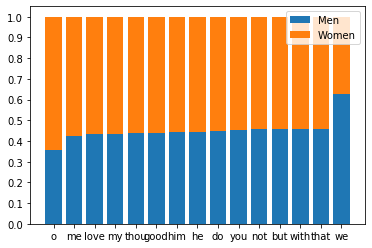

In [20]:
words = []
percent_men_values = []
percent_women_values = []

for word, percent_men in top_imbalanced_percent_men:
    words.append(word)
    percent_men_values.append(percent_men)
    percent_women_values.append(1 - percent_men)

ind = np.arange(len(words))

p1 = plt.bar(ind, percent_men_values)
p2 = plt.bar(ind, percent_women_values, bottom=percent_men_values)

plt.xticks(ind, words)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend((p1[0], p2[0]), ('Men', 'Women'))
plt.show()

Likely because of the difference in word count, we are seeing only one of the top 15 most imbalanced words being used more by men. The other 14 are all words used more frequently by female speakers.

## Remove unused columns from matrix

In [21]:
columns = frequency_matrix.columns.values
columns_to_drop = [column for column in columns if column not in top_words]
print('Number of columns in frequency matrix:', len(columns))
print('Number of columns to drop (used less than 800 times):', len(columns_to_drop))

Number of columns in frequency matrix: 8512
Number of columns to drop (used less than 800 times): 8467


In [22]:
filtered_frequency_matrix = frequency_matrix.drop(columns=columns_to_drop)
filtered_frequency_matrix

,,no,all,come,good,so,hi,have,are,i,he,...,me,but,it,shall,him,if,do,o,you,as
ant-9,Globe_Shakespeare/ant.xml,26,15,30,23,30,33,40,11,157,48,...,66,37,47,20,44,22,22,38,42,30
ros.,Globe_Shakespeare/ayl.xml,43,24,26,30,32,32,55,38,214,61,...,78,51,52,19,41,42,36,16,196,53
des.,Globe_Shakespeare/oth.xml,14,12,11,15,25,23,27,13,136,29,...,48,28,25,12,41,18,45,13,63,15
isab.,Globe_Shakespeare/mm.xml,13,9,4,15,18,26,25,9,96,35,...,35,44,49,6,24,16,18,27,51,45
jul.,Globe_Shakespeare/rom.xml,22,17,29,18,30,17,34,15,151,18,...,58,32,46,27,20,31,20,38,27,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
off.,Globe_Shakespeare/wt.xml,0,0,0,0,1,2,3,0,1,0,...,0,0,2,2,0,1,0,0,3,1
fran.,Globe_Shakespeare/tmp.xml,0,0,0,1,0,3,0,0,2,5,...,0,0,0,0,4,0,0,0,0,1
boats.,Globe_Shakespeare/tmp.xml,0,3,0,2,3,0,3,2,5,0,...,0,2,1,1,1,5,3,0,12,1
sec.-gent.,Globe_Shakespeare/cym.xml,0,0,0,0,4,1,0,0,2,0,...,1,3,0,0,2,0,1,0,3,0


## Get data from frequency matrix

Normalizing the bag of words so each row sums to 1.

In [23]:
characters = filtered_frequency_matrix.index.values

X = []

for character in characters:
    values = filtered_frequency_matrix.loc[character].values
    X.append([value / sum(values) for value in values])

X = np.array(X)

In [24]:
y = []

for character in characters:
    gender = balanced_data.loc[(balanced_data['role_id'] == character[0]) & (balanced_data['file_name'] == character[1]), 'gender']
    y.append(gender.values[0])
    
y = np.array(y)

## Split data

Choosing a test size of 0.5 based on the paper and providing a random state so that results are repeatable.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

## Naive Bayes Model

In [26]:
clf = MultinomialNB()
clf.fit(X_train, y_train)

print(clf.predict(X_test))
print(clf.score(X_test, y_test))

['MALE' 'MALE' 'MALE' 'MALE' 'MALE' 'MALE' 'MALE' 'MALE' 'MALE' 'MALE'
 'MALE' 'MALE' 'MALE' 'MALE' 'MALE' 'MALE' 'MALE' 'MALE' 'MALE' 'MALE'
 'MALE' 'MALE' 'MALE' 'MALE' 'MALE' 'MALE' 'MALE' 'MALE' 'MALE' 'MALE'
 'MALE' 'MALE' 'MALE' 'MALE' 'MALE' 'MALE' 'MALE' 'MALE' 'MALE' 'MALE'
 'MALE' 'MALE' 'MALE' 'MALE' 'MALE' 'MALE' 'FEMALE' 'MALE' 'MALE' 'MALE'
 'MALE' 'MALE' 'MALE' 'MALE' 'MALE' 'MALE' 'MALE' 'MALE' 'MALE' 'MALE'
 'MALE' 'MALE' 'MALE' 'MALE' 'MALE' 'FEMALE' 'MALE' 'MALE' 'MALE' 'MALE'
 'MALE' 'MALE' 'MALE' 'MALE' 'MALE' 'MALE' 'MALE' 'MALE' 'MALE' 'MALE'
 'MALE' 'MALE' 'FEMALE' 'MALE' 'MALE' 'MALE' 'MALE' 'MALE' 'MALE' 'MALE'
 'MALE' 'MALE' 'MALE' 'MALE' 'MALE' 'MALE' 'MALE' 'MALE' 'MALE' 'MALE'
 'MALE' 'MALE' 'MALE' 'MALE' 'MALE' 'MALE']
0.5188679245283019


### Leave on out cross validation

In [27]:
loo = LeaveOneOut()
model = MultinomialNB()
nb_results = cross_val_score(model, X, y, cv=loo)
nb_results.mean()

0.5377358490566038

## SVM Model

In [28]:
clf = LinearSVC(random_state=0)
clf.fit(X_train, y_train)

print(clf.predict(X_test))
print(clf.score(X_test, y_test))

['MALE' 'MALE' 'MALE' 'FEMALE' 'MALE' 'MALE' 'FEMALE' 'MALE' 'FEMALE'
 'FEMALE' 'MALE' 'MALE' 'FEMALE' 'FEMALE' 'MALE' 'FEMALE' 'FEMALE' 'MALE'
 'MALE' 'MALE' 'FEMALE' 'FEMALE' 'MALE' 'MALE' 'MALE' 'MALE' 'MALE'
 'FEMALE' 'FEMALE' 'FEMALE' 'MALE' 'MALE' 'MALE' 'FEMALE' 'FEMALE' 'MALE'
 'MALE' 'MALE' 'FEMALE' 'FEMALE' 'MALE' 'FEMALE' 'FEMALE' 'MALE' 'FEMALE'
 'FEMALE' 'FEMALE' 'MALE' 'FEMALE' 'FEMALE' 'FEMALE' 'MALE' 'FEMALE'
 'MALE' 'FEMALE' 'MALE' 'FEMALE' 'FEMALE' 'MALE' 'FEMALE' 'MALE' 'MALE'
 'FEMALE' 'FEMALE' 'FEMALE' 'FEMALE' 'FEMALE' 'MALE' 'FEMALE' 'FEMALE'
 'FEMALE' 'MALE' 'FEMALE' 'MALE' 'MALE' 'MALE' 'FEMALE' 'MALE' 'MALE'
 'MALE' 'FEMALE' 'MALE' 'FEMALE' 'MALE' 'FEMALE' 'FEMALE' 'MALE' 'FEMALE'
 'FEMALE' 'MALE' 'MALE' 'MALE' 'MALE' 'FEMALE' 'MALE' 'MALE' 'MALE'
 'FEMALE' 'FEMALE' 'FEMALE' 'MALE' 'FEMALE' 'FEMALE' 'MALE' 'MALE' 'MALE']
0.6792452830188679


### Leave on out cross validation

In [29]:
loo = LeaveOneOut()
model = LinearSVC(random_state=0)
svm_results = cross_val_score(model, X, y, cv=loo)
svm_results.mean()

0.6509433962264151

## Analysis

In [30]:
incorrect = [result == 0 for result in svm_results]
balanced_data[incorrect]

,role_id,role,file_name,gender,speech_count,line_count,total_words,avg_words_per_speech
90,por.,PORTIA,Globe_Shakespeare/mv.xml,FEMALE,117,1693,4609,39.393162
1077,prin.,The PRINCESS of France,Globe_Shakespeare/lll.xml,FEMALE,104,863,2139,20.567308
728,mrs.-page.,MISTRESS PAGE,Globe_Shakespeare/wiv.xml,FEMALE,103,781,2505,24.320388
727,mrs.-ford.,MISTRESS FORD,Globe_Shakespeare/wiv.xml,FEMALE,83,407,1277,15.385542
1078,ros.,ROSALINE,Globe_Shakespeare/lll.xml,FEMALE,75,530,1372,18.293333
...,...,...,...,...,...,...,...,...
404,mess.,Messenger,Globe_Shakespeare/mac.xml,MALE,6,69,175,29.166667
654,bur.,DUKE OF BURGUNDY,Globe_Shakespeare/1h6.xml,MALE,17,92,332,19.529412
422,son.,Son to Macduff,Globe_Shakespeare/mac.xml,MALE,14,48,142,10.142857
606,third-serv.,Third Servant,Globe_Shakespeare/shr.xml,MALE,4,36,98,24.500000


In [31]:
incorrect_male = len(balanced_data[incorrect & (balanced_data['gender'] == 'MALE')]) / len(balanced_data)
incorrect_female = len(balanced_data[incorrect & (balanced_data['gender'] == 'FEMALE')]) / len(balanced_data)
incorrect_greater_or_equal_500 = len(balanced_data[incorrect & (balanced_data['total_words'] >= 500)]) / len(balanced_data)
incorrect_less_than_500 = len(balanced_data[incorrect & (balanced_data['total_words'] < 500)]) / len(balanced_data)

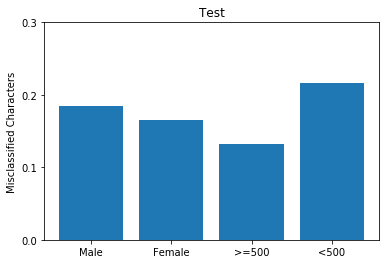

In [32]:
labels = ['Male', 'Female', '>=500', '<500']
stats = [incorrect_male, incorrect_female, incorrect_less_than_500, incorrect_greater_or_equal_500]
ind = np.arange(len(labels))
plt.bar(ind, stats)

plt.xticks(ind, labels)
plt.yticks(np.arange(0, 0.31, 0.1))
plt.ylabel('Misclassified Characters')
plt.title('Test')
plt.show()